# Lab 2 : Overview

Upon completing this lab, you should have a good understanding of the fundamentals of using OpenStreetmap maps and developing local planners for Autonomous Vehicles, along with practical experience in designing, implementing, and testing local planners in a simulated environment. This hands-on experience will prepare you for further study or work in the field of autonomous vehicles.

In [2]:
# useful imports
import matplotlib.pyplot as plt
from osmnx_utils import *
import osmnx  as ox   
import networkx as nx

/home/user/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Task n° 1 : Load and visualize OSM Maps
- This task involves loading an OpenStreetMap (OSM) map for a specified location using the osmnx library.
- It also visualizes the OSM graph, nodes, and edges for the given location 

First, you'll need to find a location of interest in an osm map: https://www.openstreetmap.org

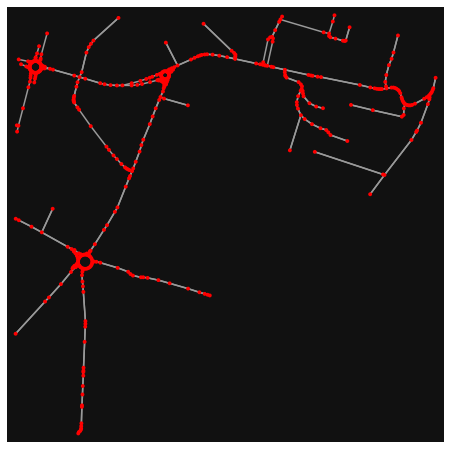

In [3]:
def create_config():
   # Place you are interested : 
    location = (47.2489965, -1.5473425) # Nantes, Ecole Centrale
    mode = "drive"
    ox.config(log_console=False, use_cache=True)

    G = ox.graph_from_point(location, dist=500, simplify=False, network_type=mode )
    return(G)

G = create_config()
# TODO : Plot the graph and nodes
fig, ax = ox.plot_graph(G,node_color='r', edge_linewidth=1.5, edge_alpha=1.0)


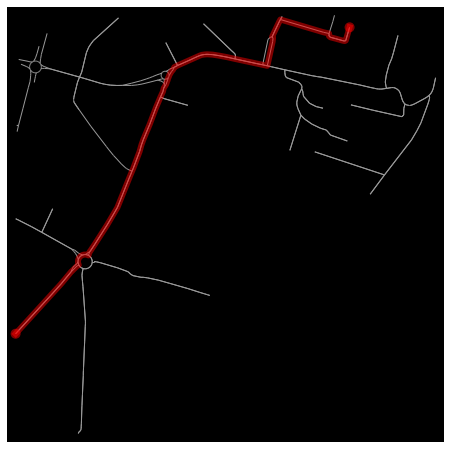

In [4]:
origin = (round(-1.5562600,6), round(47.2467100,6))
destination = (round(-1.5428700,6), round(47.2533500,6))
origin_node = ox.nearest_nodes(G, origin[0], origin[1])

destination_node = ox.nearest_nodes(G, destination[0], destination[1])

# TODO: find the path from origin to destination, using nx library
path = nx.shortest_path(G, origin_node, destination_node)

# TODO: plot the path on the graph
fig, ax = ox.plot_graph_route(G, path, route_linewidth=6, node_size=0, bgcolor='k')


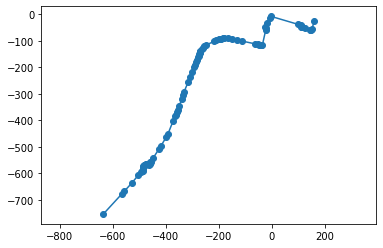

In [5]:
nodes_proj, edges_proj = ox.graph_to_gdfs(G, nodes=True, edges=True)
wpts = gdfs_to_local(nodes_proj, path) # TODO: convert to local coordinates
plt.plot(wpts[:,0], wpts[:,1], 'o-')
plt.axis("equal")
plt.show()

# Task 2: Implement a Global Planner
- In this task, you load a pre-existing road network graph (Town 01 Road Network) and actor positions.
- You also create a custom A* algorithm and heuristic function to find a path from the ego vehicle's current position to a specified target

In [6]:
import pickle

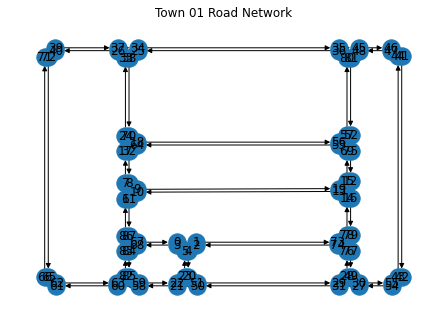

In [7]:
nodes =  pickle.load(open('/home/user/DeepAccident_custom/test_TP/labs/lab2/Town01_nodes.pickle', 'rb'))
edges =  pickle.load(open('/home/user/DeepAccident_custom/test_TP/labs/lab2/Town01_edges.pickle', 'rb'))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
node_positions = {waypoint[0]: (waypoint[1]["vertex"][0], waypoint[1]["vertex"][1]) for waypoint in G.nodes.data()}

nx.draw(G,node_positions, with_labels=True)
plt.title("Town 01 Road Network")
plt.show()


In [8]:
from utils import get_actor_T_world

actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind"]
N_frames = 100 
# colors = ['ro', 'go', 'bo', 'mo']
# for i in range(len(actors)):
#     for n_frame in range(N_frames):
#         T = get_actor_T_world(actors[i], n_frame)
#         plt.plot(T[0,-1], T[1,-1], colors[i])
# nx.draw(G,node_positions, node_size=50)
# plt.title("Town 01 Road Network : Zoom on scenario")

# plt.show()

In [9]:
# Define a custom A* algorithm TODO: implement the algorithm
def custom_a_star(graph, start, end, heuristic_func):
    open_set = {start}
    came_from = {}
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start] = heuristic_func(start, end)

    while open_set:
        current = min(open_set, key=lambda node: f_score[node])
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        open_set.remove(current)
        for neighbor in graph.neighbors(current):
            tentative_g_score =  g_score[current] + graph[current][neighbor]['length']
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] =  g_score[neighbor] + heuristic_func(neighbor, end)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

# Define a custom heuristic function (e.g., Euclidean distance)
def custom_heuristic(node, end):
    x1, y1, _= G.nodes[node]["vertex"]
    x2, y2, _ = G.nodes[end]["vertex"]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5



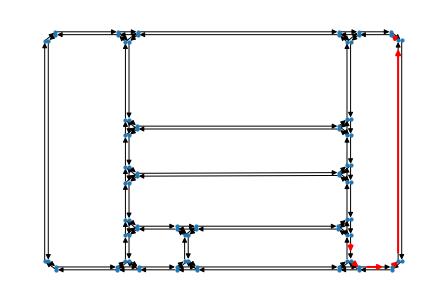

In [10]:
# find closest node to ego vehicle
ego_vehicle = "ego_vehicle"
ego_vehicle_pos = get_actor_T_world(ego_vehicle, 0)
ego_vehicle_pos = ego_vehicle_pos[:2,-1]

def closest_node(G, pos):
    closest_node = min(G.nodes, key=lambda node: ((pos[0] - G.nodes[node]['vertex'][0]) ** 2 + (pos[1] - G.nodes[node]['vertex'][1]) ** 2) ** 0.5)
    return closest_node

origin = closest_node(G, ego_vehicle_pos)
end = 47
path = custom_a_star(G, origin, end, custom_heuristic)
nx.draw(G, node_positions,node_size=10)

# Draw the path on top of the graph
path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)
plt.show()


# Task 3: Implement a Local Planner - DWA Approach
- This task implements the Dynamic Window Approach (DWA) for local planning. It defines various parameters such as maximum velocity, acceleration, and rotation.
- It simulates the DWA algorithm to generate a trajectory that minimizes a cost function. The trajectory is then plotted.

In [11]:
# Constants
MAX_VELOCITY = 13.0  # Maximum linear velocity (m/s)
MAX_ACCELERATION = 0.2  # Maximum linear acceleration (m/s^2)
MAX_ROTATION = 2.0  # Maximum rotational velocity (rad/s)


# DWA parameters
NUM_THETA = 11  # Number of angular velocity samples
NUM_V = 11  # Number of linear velocity samples
DT = 0.1  # Time step for simulation

# Function to calculate a cost for a given trajectory
def calculate_cost(trajectory, target, obstacles):
    # Implement your cost function here, considering factors like distance to target and obstacles.
    # This is a simplified placeholder, and in a real application, you would use sensor data to evaluate costs.
    dist_cost = np.linalg.norm(trajectory[-1][:2] - target[:2])
    speed_cost = 1/(np.linalg.norm(trajectory[-1][:2] - trajectory[-2][:2]) / DT)
    return dist_cost + speed_cost

# Evolution model 
def evolve(current_state, v, w):
    x, y, theta = current_state
    x += -v * np.cos(theta) * DT
    y += -v * np.sin(theta) * DT
    theta += w * DT
    return np.array([x, y, theta])

# DWA algorithm
def dynamic_window_approach(current_state, target, obstacles):
    best_trajectory = None
    best_commands = None
    min_cost = float('inf')

    for v in np.linspace(4.0, MAX_VELOCITY, NUM_V):
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(10):  # Simulate for 1 second with evolution model
                trajectory.append(evolve(trajectory[-1], v, w))

            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles)

            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory
                best_commands = (v, w)

    return best_trajectory, best_commands

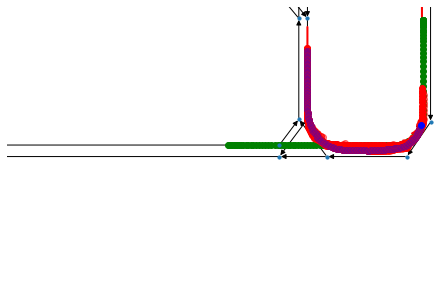

In [12]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)

obstacles = []  # List of obstacle positions
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)
path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(5)]
next_waypoint = path_loop.pop(0)
i=0
while path_loop and i<100:
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)
        
    resulting_trajectory, cmds = dynamic_window_approach(current_state, np.array(next_waypoint), obstacles)
    
    # Move along the trajectory (simulated)
    for state in resulting_trajectory:
        current_state = state
        plt.plot(current_state[0], current_state[1], 'ro', alpha=0.5)

    current_state = resulting_trajectory[1]
    plt.plot(current_state[0], current_state[1], 'bo')
    i+=1
plt.xlim(200,400)
plt.ylim(-50,50)

for n_frame in range(N_frames):
    T = get_actor_T_world(ego_vehicle, n_frame)
    plt.scatter(T[0,-1], T[1,-1], color = 'r')
    T = get_actor_T_world("other_vehicle", n_frame)
    plt.scatter(T[0,-1], T[1,-1], color = 'g')

plt.show()

# Task 4: Implement a DWA Approach with Obstacle Avoidance
- This task extends the DWA approach to include obstacle avoidance. Obstacle positions (both static and dynamic) are considered when calculating the cost of a trajectory.
- The code predicts the future positions of dynamic obstacles.
- It then simulates the DWA approach while avoiding both static and dynamic obstacles.

In [34]:
ROBOT_RADIUS = 3 # Robot radius (m)
OBS_RADIUS = 3  # Radius of obstacles (m)

# Function to calculate a cost for a given trajectory considering proximity to obstacles
def calculate_cost(trajectory, target, obstacles, dynamic_obstacles):
    dist_cost = np.linalg.norm(trajectory[-1][:2] - target[:2])
    speed_cost = 0
    cost = dist_cost + speed_cost
    # Add a penalty for proximity to static obstacles
    for obs in obstacles:
        distances = np.linalg.norm(trajectory[-1][:2] - np.array(obs))
        min_distance = ROBOT_RADIUS + OBS_RADIUS
        cost += max(0, min_distance - distances)

    # Add a penalty for proximity to dynamic obstacles
    for obs in dynamic_obstacles:
        obs_trajectory = predict_dynamic_obstacles(obs, len(trajectory))
        plt.plot(obs_trajectory[1][0], obs_trajectory[1][1], 'ro')
        for i in range(len(trajectory)):
            distance = np.linalg.norm(trajectory[i][:2] - obs_trajectory[i])
            if distance < ROBOT_RADIUS + OBS_RADIUS:
                cost += (ROBOT_RADIUS + OBS_RADIUS - distance)

    return cost

# Function to predict future positions of dynamic obstacles
def predict_dynamic_obstacles(dynamic_obstacle, num_steps):
    x,y,v_x, v_y = dynamic_obstacle
    positions = []
    for _ in range(num_steps):
        x += v_x * DT
        y -= v_y * DT
        positions.append((x, y))
    
    return positions

# DWA algorithm with dynamic obstacle avoidance and proximity to obstacles
def dynamic_window_approach_avoidance(current_state, target, obstacles, dynamic_obstacles):
    best_trajectory = None
    min_cost = float('inf')

    # Predict future positions of dynamic obstacles
    num_prediction_steps = 10

    for v in np.linspace(0, MAX_VELOCITY, NUM_V):
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(num_prediction_steps):  # Simulate for predicted time
                x, y, theta = trajectory[-1]
                x += -v * np.cos(theta) * DT
                y += -v * np.sin(theta) * DT
                theta += w * DT
                trajectory.append(np.array([x, y, theta]))

            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles, dynamic_obstacles)

            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory

    return best_trajectory

[(302.0636333733364, 1.9760212608379628, 5.0, 0.0)]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following trajectory to target: [339.  11.   0.]
Following traject

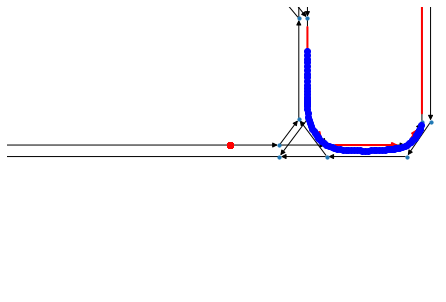

Reached the target: [391.63258501   8.83469653   4.29079633]


In [35]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)

obstacles = []  # List of obstacle positions
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)
path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(5)]
next_waypoint = path_loop.pop(0)
x,y  = get_actor_T_world('other_vehicle', 0)[:2,-1]
dynamic_obstacles = [(x,y,13.8,0.0)]
print(dynamic_obstacles)
i=0
while path_loop and i<100:
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)

    resulting_trajectory  = dynamic_window_approach_avoidance(current_state, np.array(next_waypoint), obstacles, dynamic_obstacles)
    print("Following trajectory to target:", np.array(next_waypoint))
    # Move along the trajectory (simulated)
    current_state = resulting_trajectory[1]
    i+=1
    plt.plot(current_state[0], current_state[1], 'bo')
# for n_frame in range(N_frames):
#     # T = get_actor_T_world(ego_vehicle, n_frame)
#     # plt.scatter(T[0,-1], T[1,-1], color = 'r')
#     T = get_actor_T_world("other_vehicle", n_frame)
#     plt.scatter(T[0,-1], T[1,-1], color = 'g')
plt.xlim(200,400)
plt.ylim(-50,50)
plt.show()

print("Reached the target:", current_state)